## VaR Parametrical

We will use yfinance library to download historical stock price data. Remember we can use also an Excel or csv file to get data.

In this practice exercise we consider an equally weighted portfolio (it can be changed).

In [1]:
# Libraries:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

1 -  Set time range.
 - This is optional, we can set a specific time range here or in the data download code.

In [2]:
years = 3

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

2 - Create a list of tickers

In [3]:
tickers = ["OR.PA","XOM","BRK-B","GOOG","PFE"]

3 - Set the Weights (equally weighted portfolio). And the Portfolio Value ($1,000,000)

In [4]:
portfolio_value = 1000000

# weights = np.array([0.25, 0.25, 0.2, 0.15, 0.15 ])  Code for a non-equally weighted portfolio
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


4 - Download daily adjusted close price for the tickers

- We use AdjClosePrices instead of ClosePrice due to the dividend and split adjustments.

In [5]:
#close_df = yf.download(tickers, start="2020-11-01", end="2023-11-05")["Close"]   #We can set a specific time range here
adj_close_df = yf.download(tickers, start=startDate, end=endDate)["Adj Close"]
adj_close_df.head()

[*********************100%%**********************]  5 of 5 completed


,BRK-B,GOOG,OR.PA,PFE,XOM
Date,,,,,
2021-01-20,NaN,NaN,282.085938,NaN,NaN
2021-01-21,234.160004,94.562500,283.046722,32.526329,42.154427
2021-01-22,232.919998,95.052498,284.680023,32.588734,41.558609
2021-01-25,233.009995,94.970001,287.274170,33.239620,41.094219
2021-01-26,231.570007,95.862000,289.964325,33.266373,40.191723


5 - Calculate the daily log returns and drop any N/A value

In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna() #Drop N/A values
log_returns.head()

,BRK-B,GOOG,OR.PA,PFE,XOM
Date,,,,,
2021-01-22,-0.005310,0.005168,0.005754,0.001917,-0.014235
2021-01-25,0.000386,-0.000868,0.009071,0.019776,-0.011237
2021-01-26,-0.006199,0.009349,0.009321,0.000805,-0.022206
2021-01-27,-0.018348,-0.046139,-0.014014,-0.029098,-0.011401
2021-01-28,0.015667,0.017500,-0.000672,0.000279,0.015535


6 - Calculating Historical Portfolio Returns

- Sum(Returns * weight)  of every stock

In [8]:
historical_returns = (log_returns * weights).sum(axis =1)
print(historical_returns.head())

Date
2021-01-22   -0.001341
2021-01-25    0.003426
2021-01-26   -0.001786
2021-01-27   -0.023800
2021-01-28    0.009661
dtype: float64


7 - Finding N-Day Historical Returns (Sum of returns for a specific number/range of days N)

In [13]:
days = 5

historical_n_day_returns = historical_returns.rolling(window=days).sum()
historical_n_day_returns = historical_n_day_returns.dropna() #Drop N/A values
print(historical_n_day_returns)

Date
2021-01-28   -0.013840
2021-01-29   -0.028261
2021-02-01   -0.019231
2021-02-02   -0.012345
2021-02-03    0.031258
                ...   
2024-01-11   -0.002369
2024-01-12    0.003134
2024-01-17   -0.008710
2024-01-18   -0.002335
2024-01-19    0.008645
Length: 713, dtype: float64


8 - Covariance Matrix and Calculate Portfolio Standar Deviation

In [14]:
cov_matrix = log_returns.cov() * 252   #For 1 year (252 business days)
print(cov_matrix)

portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
print("Portfolio STD DEV: ",portfolio_std_dev)

          BRK-B      GOOG     OR.PA       PFE       XOM
BRK-B  0.031285  0.025661  0.010903  0.014509  0.023228
GOOG   0.025661  0.100628  0.019374  0.012400  0.013340
OR.PA  0.010903  0.019374  0.054911  0.007690  0.002221
PFE    0.014509  0.012400  0.007690  0.064685  0.008411
XOM    0.023228  0.013340  0.002221  0.008411  0.087199
Portfolio STD DEV:  0.15673932569119078


### Calculating VaR (Parametrical method)

Lets use different confidence levels (90%, 95% and 99%) and calculate the Value at Risk (VaR)

- Rememeber the higher we set our confidence interval & days; the greater our VaR is

In [15]:
confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days / 252)
    VaRs.append(VaR)

print("VaR for each CL: ",VaRs)

# Print VaR Results con formato bonito
print('-' * 40)
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

VaR for each CL:  [28294.289403681887, 36315.32729460123, 51361.46041363555]
----------------------------------------
Confidence Level     Value at Risk       
----------------------------------------
    90%:          $ 28,294.29
    95%:          $ 36,315.33
    99%:          $ 51,361.46


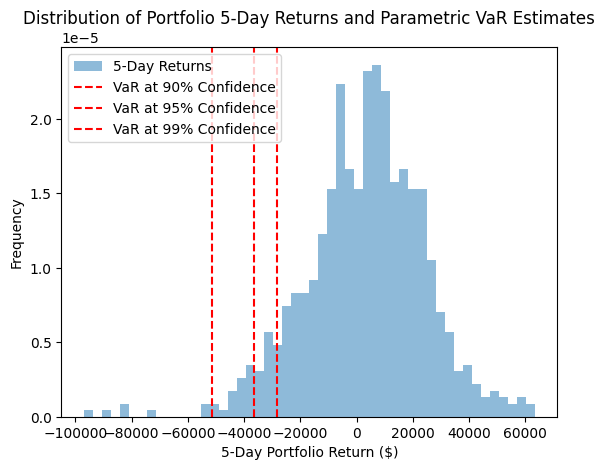

In [17]:
# Plot the Distribution of Portfolio Returns and Parametric VaR Estimates
# we will plot the distribution of the X-day portfolio returns and the parametric VaR estimates:

# Convert returns to dollar values for the histogram
historical_n_day_returns_dollar = historical_n_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_n_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()